*First compiled: May 2, 2017.*

# DPT for hematopoiesis in mouse [Paul *et al.*, Cell (2015)](http://doi.org/10.1016/j.cell.2015.11.013)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.*, Cell (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

**Attention:** For a more recent and richer analysis of this dataset take a look at https://github.com/theislab/graph_abstraction/tree/master/paul15.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_version_and_date()
# we will soon provide an update with more recent dependencies
sc.logging.print_versions_dependencies_numerics()

Running Scanpy 0.3.2 on 2017-11-29 23:03.
Dependencies: numpy==1.13.3 scipy==1.0.0 pandas==0.21.0 scikit-learn==0.18.2 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.5.2+274.g35181a7 


### Simple DPT analysis

Perform a Diffusion Pseudotime analysis on raw data, as in [Haghverdi *et al.* (2016)](http://doi.org/10.1038/nmeth.3971). No preprocessing, only logarthmize the raw counts.

Note: The following function is also available as `sc.datasets.paul15_raw()`.

In [2]:
def paul15_raw():
    import h5py
    filename = 'data/paul15/paul15.h5'
    backup_url = 'http://falexwolf.de/data/paul15.h5'
    sc.utils.check_presence_download(filename, backup_url)
    with h5py.File(filename, 'r') as f:
        X = f['data.debatched'][()]
        gene_names = f['data.debatched_rownames'][()].astype(str)
        cell_names = f['data.debatched_colnames'][()].astype(str)
        clusters = f['cluster.id'][()].flatten()
        infogenes_names = f['info.genes_strings'][()].astype(str)                                                                                                                                
    # each row has to correspond to a sample, therefore transpose                                                                                                                    
    adata = sc.AnnData(X.transpose())
    adata.var_names = gene_names
    adata.row_names = cell_names
    # names reflecting the cell type identifications from the paper                                                                                                                                                                                                                                                    
    cell_type = {7: 'MEP', 8: 'Mk', 9: 'GMP', 10: 'GMP', 11: 'DC',
                 12: 'Baso', 13: 'Baso', 14: 'Mo', 15: 'Mo',
                 16: 'Neu', 17: 'Neu', 18: 'Eos', 19: 'Lymph'}
    cell_type.update({i: 'Ery' for i in range(1, 7)})
    adata.smp['paul15_clusters'] = [
        str(i) + cell_type[i] for i in clusters.astype(int)]                                                                                                                   
    # make string annotations categorical (optional)                                                                                                                           
    sc.utils.sanitize_anndata(adata)                                                                                                                                                 
    # just keep the first of the two equivalent names per gene                                                                                                                       
    adata.var_names = [gn.split(';')[0] for gn in adata.var_names]                                                                                                       
    # remove 10 corrupted gene names                                                                                                                                                 
    infogenes_names = np.intersect1d(infogenes_names, adata.var_names)                                                                                                               
    # restrict data array to the 3461 informative genes                                                                                                                              
    adata = adata[:, infogenes_names]                                                                                                                                                
    # usually we'd set the root cell to an arbitrary cell in the MEP cluster                                                                                                         
    # adata.uns['iroot': np.flatnonzero(adata.smp['paul15_clusters']  == '7MEP')[0]                                                                                                
    # here, set the root cell as in Haghverdi et al. (2016)                                                                                                                          
    adata.uns['iroot'] = 840  # note that other than in Matlab/R, counting starts at 1
    return adata

In [3]:
adata = paul15_raw()
# logarithmize data
sc.pp.log1p(adata)

... storing paul15_clusters as categorical type
--> access categories as adata.smp.paul15_clusters.cat.categories


In [4]:
sc.tl.dpt(adata, n_branchings=1, n_neighbors=20, n_pcs=0)

perform Diffusion Pseudotime analysis
    using data matrix X directly for building graph (no PCA)
    computing data graph with n_neighbors = 20 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            0.9922149777  0.9660109878  0.9404994249  0.927308917
      0.8855163455  0.8672742844  0.8413332701  0.8286701441  0.8070437312]
    detect 1 branching
    do not consider groups with less than 27 points for splitting
    branching 1: split group 0
finished (0:00:03.021) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)


Diffusion Pseudotime (DPT) analysis detects the branch of granulocyte/macrophage progenitors (GMP), and the branch of megakaryocyte/erythrocyte progenitors (MEP). There are two small further subgroups (segments 0 and 2).

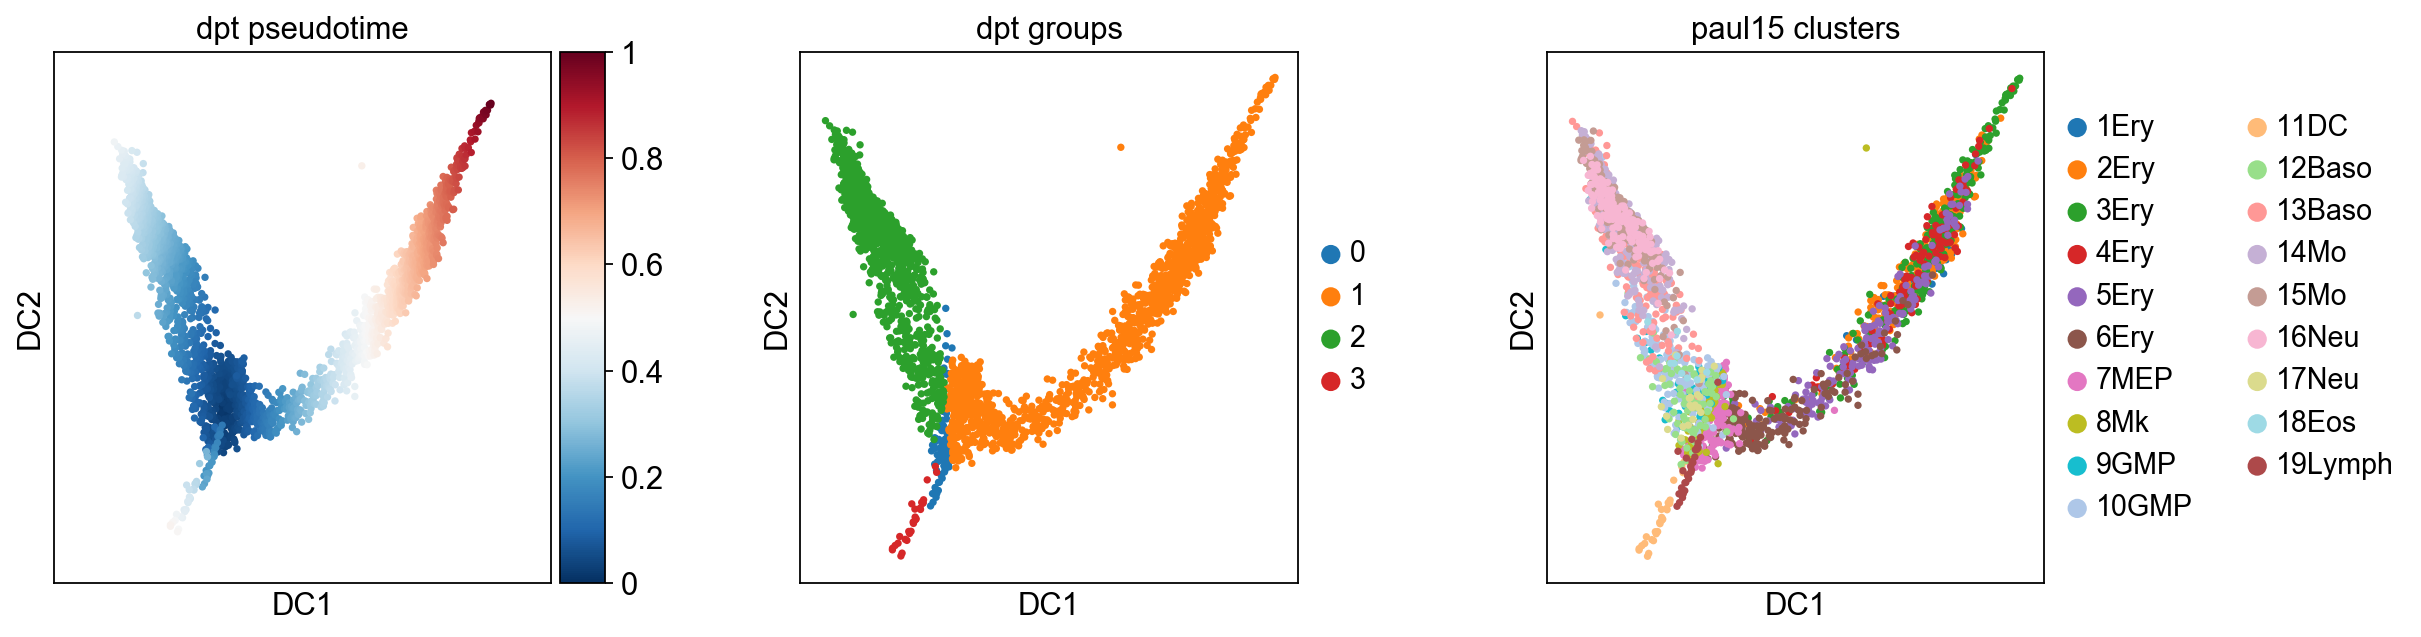

In [5]:
sc.pl.dpt_scatter(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])

With this, we reproduced the analysis of [Haghverdi *et al.* (2016, Suppl. Note 4 and Suppl. Figure N4)](https://doi.org/10.1038/nmeth.3971).

### Visualize with tSNE

It's always good to look at a second visualization.

In [6]:
sc.tl.tsne(adata)

computing tSNE
    compute 'X_pca' with n_pcs = 50
--> avoid this by setting n_pcs = 0
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:09.088) --> added
    'X_tsne', tSNE coordinates (adata.smp)


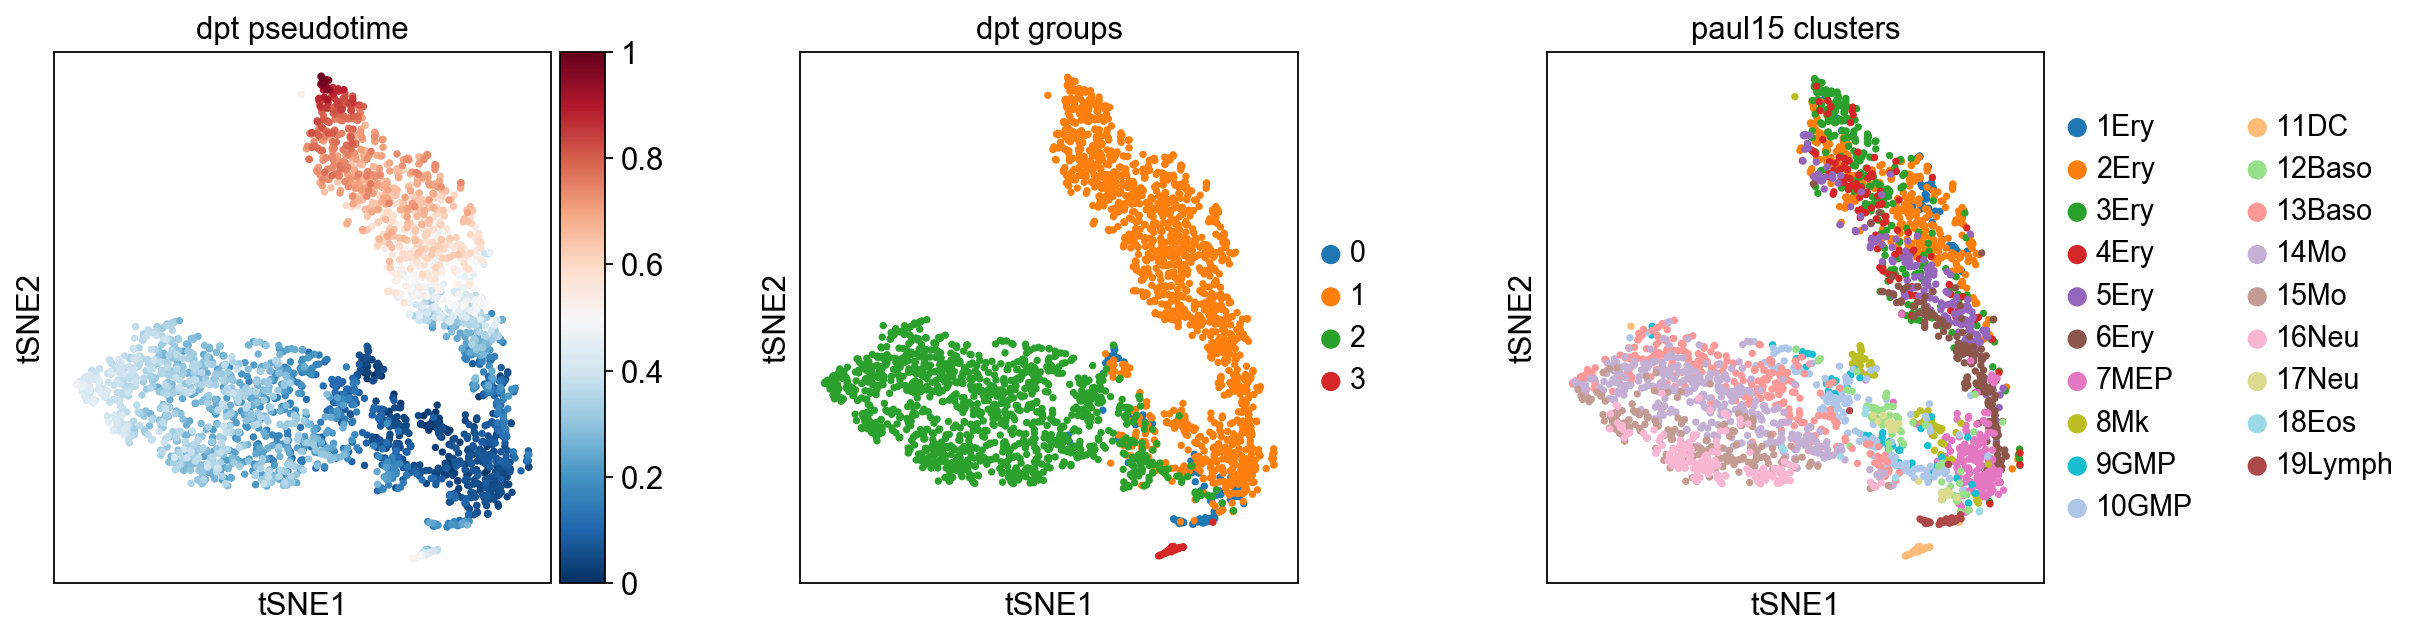

In [7]:
axs = sc.pl.tsne(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])

### Using a preprocessing recipe

To make the geometry of the data pronounced, select highly variable genes as done by [Zheng *et al.*, (2017)](http://doi.org/10.1038/ncomms14049).

In [8]:
adata = paul15_raw()
sc.pp.recipe_zheng17(adata)

... storing paul15_clusters as categorical type
--> access categories as adata.smp.paul15_clusters.cat.categories
normalizing by total count per cell
    finished (0:00:00.068): normalized adata.X and added
    'n_counts_all', counts per cell before normalization (adata.smp)
filter highly variable genes by dispersion and mean (0:00:00.250)
normalizing by total count per cell
    finished (0:00:00.042): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.smp)


Let us compute the tSNE coordinates for visualization.

computing tSNE
    compute 'X_pca' with n_pcs = 50
--> avoid this by setting n_pcs = 0
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:07.846) --> added
    'X_tsne', tSNE coordinates (adata.smp)


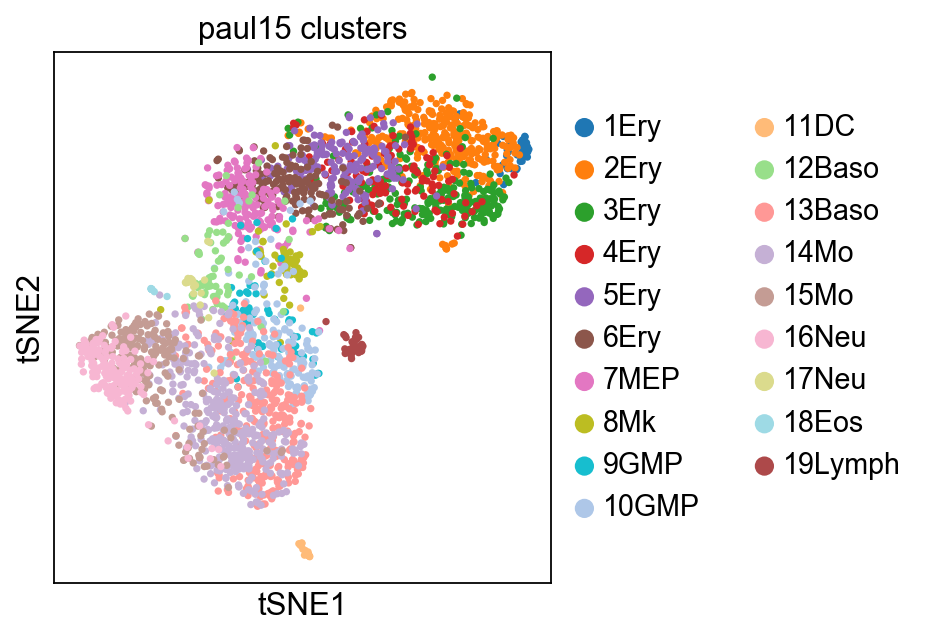

In [9]:
sc.tl.tsne(adata)
axs = sc.pl.tsne(adata, color=['paul15_clusters'])

Detect the single branching into myeloids and erythroids.

In [10]:
sc.tl.dpt(adata, n_branchings=1, n_neighbors=20)

perform Diffusion Pseudotime analysis
    using 'X_pca' with n_pcs = 50 for building graph
    computing data graph with n_neighbors = 20 
    computing spectral decomposition ("diffmap") with 10 components
    eigenvalues of transition matrix
    [ 1.            0.9899151921  0.9675537348  0.9564409852  0.93884027
      0.91275841    0.8792349696  0.8754199743  0.8671839833  0.8410307765]
    detect 1 branching
    do not consider groups with less than 27 points for splitting
    branching 1: split group 0
finished (0:00:02.236) and added
    "dpt_pseudotime", the pseudotime (adata.smp),
    "dpt_groups", the branching subgroups of dpt (adata.smp)
    "dpt_order", order according to groups and increasing pseudtime (adata.smp)


Now DPT finds the branch of dendritic cells.

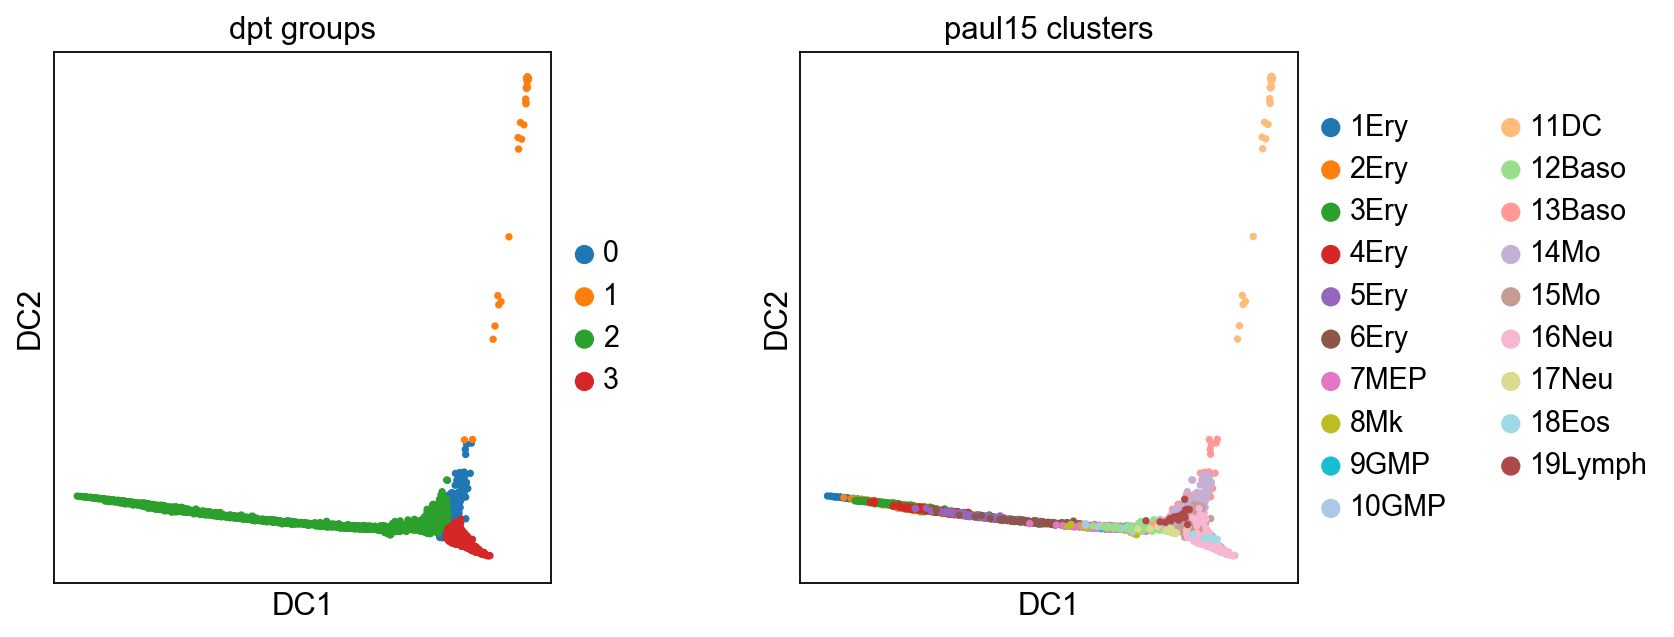

In [11]:
axs = sc.pl.diffmap(adata, color=['dpt_groups', 'paul15_clusters'])

Brnach 3 is solely composed of myeloids, but branch 2 contains erythroids and myeloids.

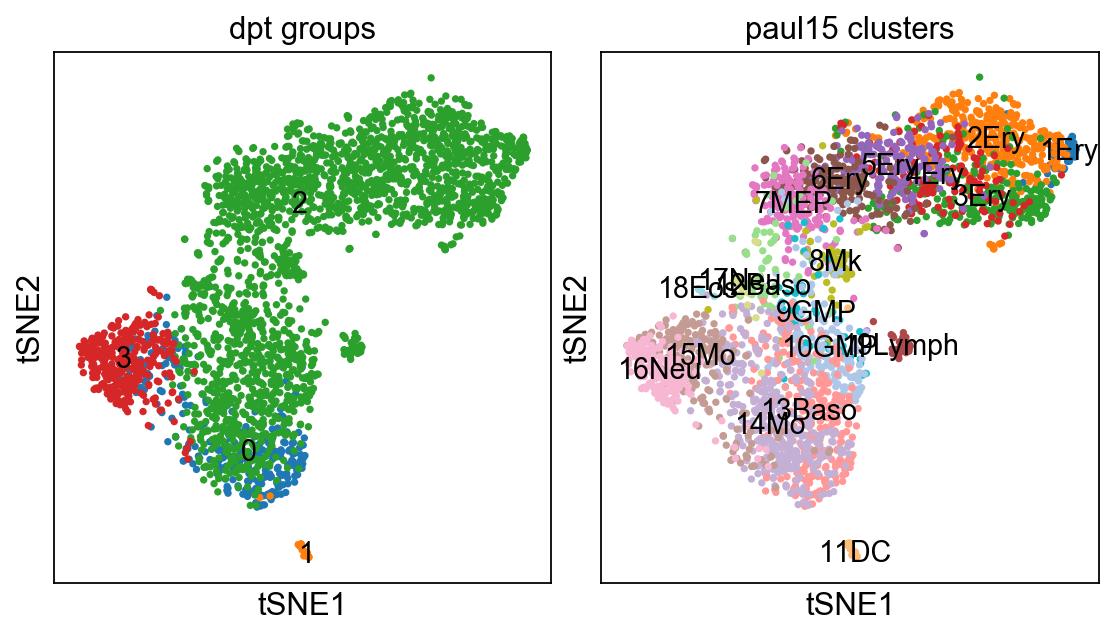

In [12]:
axs = sc.pl.tsne(adata, color=['dpt_groups', 'paul15_clusters'], legend_loc='on data')

Saving the results.

In [13]:
sc.write('paul15', adata)